###### 1. Setup

1.1 Install Required Libraries

In [1]:
!pip install tensorflow==2.19.0 opencv-python matplotlib

1.2 Import Necessary Packages

# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

1.3 Configure GPU Memory Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

1.4 Create Required Directory Structure

In [4]:
import os
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')
ANC_PATH = ANC_PATH.replace('\\', '/')
POS_PATH = POS_PATH.replace('\\', '/')
NEG_PATH = NEG_PATH.replace('\\', '/')

In [5]:
import os
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

2. Collect Positive and Anchor Samples

2.1 Extract the Labelled Faces in the Wild (LFW) Dataset

# Đường dẫn tới trang web chứa bộ dữ liệu LFW (Labeled Faces in the Wild)
# Bộ dữ liệu này được sử dụng cho các bài toán nhận diện khuôn mặt
# Trang web: http://vis-www.cs.umass.edu/lfw/

# Giải nén các khuôn mặt được gắn nhãn Tar GZ trong tập dữ liệu tự nhiên
!tar -xf lfw.tgz

# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

2.2 Collect Positive and Anchor Image Classes

In [6]:
# Import uuid library to generate unique image names
import uuid

In [7]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor\\4b564240-5eb8-11f0-8be3-005056c0000a.jpg'

In [8]:
# Kết nối webcam
import cv2
import os
import uuid

cap = cv2.VideoCapture(0)

while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        print("Không đọc được khung hình từ webcam.")
        break

    # Lấy kích thước ảnh hiện tại
    h, w, _ = frame.shape
    
    # Tâm cắt
    center_y, center_x = h // 2, w // 2
    half_size = 125  # Vì size = 250
    
    # Giới hạn để không vượt ra ngoài ảnh
    top = max(0, center_y - half_size)
    bottom = min(h, center_y + half_size)
    left = max(0, center_x - half_size)
    right = min(w, center_x + half_size)
    
    # Cắt khung hình vuông 250x250px từ giữa ảnh
    cropped_frame = frame[top:bottom, left:right]
    
    # Ghi ảnh anchor nếu nhấn phím 'a'
    if cv2.waitKey(1) & 0xFF == ord('a'):
        imgname = os.path.join(ANC_PATH, f'{uuid.uuid1()}.jpg')
        cv2.imwrite(imgname, cropped_frame)
    
    # Ghi ảnh positive nếu nhấn phím 'p'
    if cv2.waitKey(1) & 0xFF == ord('p'):
        imgname = os.path.join(POS_PATH, f'{uuid.uuid1()}.jpg')
        cv2.imwrite(imgname, cropped_frame)
    
    # Hiển thị khung hình
    cv2.imshow('Image Collection', cropped_frame)
    
    # Thoát khi nhấn 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

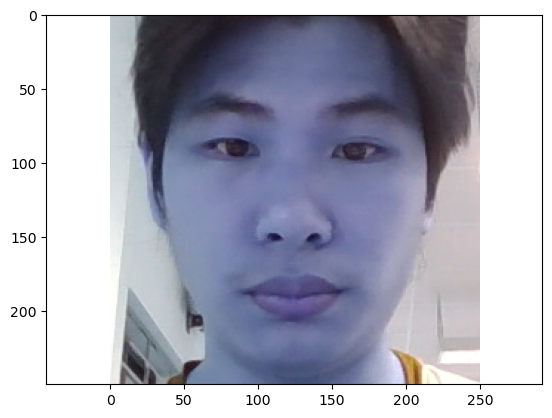

In [9]:
import matplotlib.pyplot as plt
plt.imshow(frame[120:120+250,200:200+250, :])
plt.axis('equal')  # hoặc plt.gca().set_aspect('equal', adjustable='box')
plt.show()

3. Load and Preprocess Images

3.1 Get Image Directories

In [10]:
print(ANC_PATH)  # Đảm bảo ra: data/anchor
anchor = tf.data.Dataset.list_files(f"{ANC_PATH}/*.jpg").take(3000)


data/anchor


In [11]:

# Tạo các tập dữ liệu TensorFlow từ các file ảnh trong các thư mục ANC_PATH, POS_PATH và NEG_PATH

# Tạo tập dữ liệu anchor từ các file ảnh trong thư mục ANC_PATH, Lấy 3000 ảnh
anchor = tf.data.Dataset.list_files(f"{ANC_PATH}/*.jpg").take(3000)

# Tạo tập dữ liệu positive từ các file ảnh trong thư mục POS_PATH, Lấy 3000 ảnh
positive = tf.data.Dataset.list_files(f"{POS_PATH}/*.jpg").take(3000)

# Tạo tập dữ liệu negative từ các file ảnh trong thư mục NEG_PATH, Lấy 3000 ảnh
negative = tf.data.Dataset.list_files(f"{NEG_PATH}/*.jpg").take(3000)


In [12]:

#Tạo một iterator từ tập dữ liệu anchor để duyệt qua các phần tử dưới dạng numpy array
dir_test = anchor.as_numpy_iterator()


In [13]:

# In ra đường dẫn của phần tử tiếp theo tiếp theo trong iterator
print(dir_test.next())


b'data\\anchor\\a87ed5e6-5d73-11f0-b3dc-005056c0000a.jpg'


3.2 Preprocessing - Scale and Resize

In [14]:

def preprocess(file_path):
    # Kiểm tra kiểu dữ liệu đầu vào
    if isinstance(file_path, tf.Tensor) and file_path.dtype != tf.string:
        # Nếu đã là tensor hình ảnh, không cần đọc file
        img = file_path
    else:
        # Nếu là đường dẫn dạng chuỗi, đọc file
        byte_img = tf.io.read_file(file_path)
        # Giải mã ảnh JPEG
        img = tf.io.decode_jpeg(byte_img)
    
    # Tiếp tục xử lý hình ảnh - thay đổi kích thước thành 100x100x3
    img = tf.image.resize(img, (100, 100))
    # Chuẩn hóa ảnh để giá trị pixel năm trong khoảng từ 0 đến 1
    img = img / 255.0  

    # Trả về ảnh đã tiền xử lý
    return img
    

In [15]:
img = preprocess('data\\anchor\\cfd07c4e-315d-11f0-8c07-1268382a1c50.jpg')

In [16]:
img.numpy().max() 

1.0

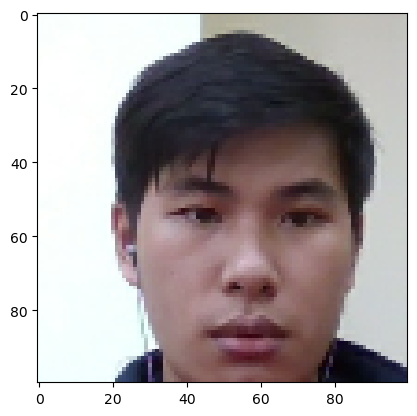

In [17]:
plt.imshow(img)

dataset = tf.data.Dataset.from_tensor_slices(img)
dataset = dataset.map(preprocess)

3.3 Create Labelled Dataset

In [18]:

# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0


In [19]:

# Tạo các cặp (anchor, positive) với nhãn 1
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))

# Tạo các cặp (anchor, negative) với nhãn 0
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

# Kết hợp hai tập dữ liệu lại với nhau
data = positives.concatenate(negatives)


In [20]:
samples = data.as_numpy_iterator()

In [21]:
exampple = samples.next()

In [22]:
exampple

(b'data\\anchor\\a9732bed-5d73-11f0-9dca-005056c0000a.jpg',
 b'data\\positive\\son tung.jpg',
 1.0)

3.4 Build Train and Test Partition

In [23]:

def preprocess_twin(input_img, validation_img, label):
    # Tiền xử lý ảnh đầu vào và ảnh kiểm tra
    return(preprocess(input_img), preprocess(validation_img), label)
    

In [24]:
res = preprocess_twin(*exampple)

In [25]:
res[0]

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.12254902, 0.13431373, 0.16176471],
        [0.1245098 , 0.13333334, 0.16176471],
        [0.12352941, 0.12352941, 0.15490197],
        ...,
        [0.12769608, 0.15122549, 0.19828431],
        [0.14142157, 0.17083333, 0.21495098],
        [0.14901961, 0.18039216, 0.23137255]],

       [[0.12352941, 0.13529412, 0.16078432],
        [0.1242647 , 0.13333334, 0.15955882],
        [0.1264706 , 0.12892157, 0.15294118],
        ...,
        [0.1375    , 0.16397059, 0.20514706],
        [0.14803922, 0.17156863, 0.21862745],
        [0.15490197, 0.18627451, 0.22941177]],

       [[0.12941177, 0.13529412, 0.15490197],
        [0.1257353 , 0.13112745, 0.15073529],
        [0.11960784, 0.12279411, 0.14460784],
        ...,
        [0.14583333, 0.16642156, 0.20833333],
        [0.15784314, 0.18210784, 0.22769608],
        [0.16862746, 0.19411765, 0.24019608]],

       ...,

       [[0.69215685, 0.72107846, 0.6757353 ],
        [0.70

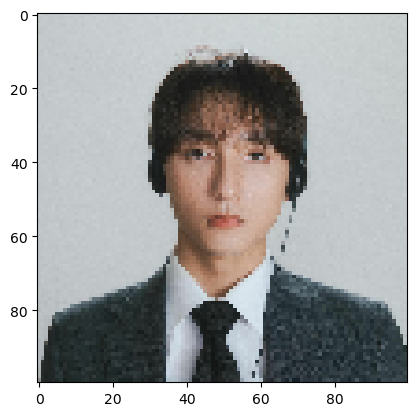

In [26]:
plt.imshow(res[1])

In [27]:
res[2]

1.0

In [28]:
# Xây dựng pipeline cho dataloader

# Áp dụng hàm tiền xử lý cho từng cặp ảnh và nhãn trong tập dữ liệu
data = data.map(preprocess_twin)

# Lưu trữ dữ liệu đã tiền xử lý vào bộ nhớ cache để tăng tốc độ truy cập
data = data.cache()

# Xáo trộn dữ liệu với buffer_size là 1024 để đảm bảo tính ngẫu nhiên
data = data.shuffle(buffer_size=1024)


In [29]:
samples = data.as_numpy_iterator()

In [30]:
len(samples.next())

3

In [31]:
samp = samples.next()

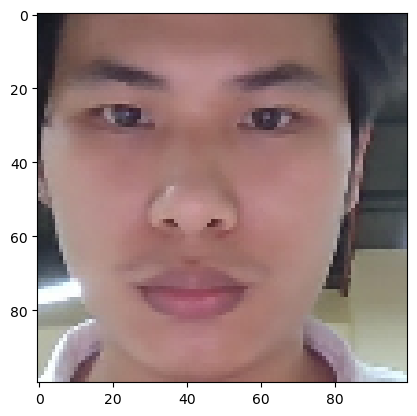

In [32]:
plt.imshow(samp[0])

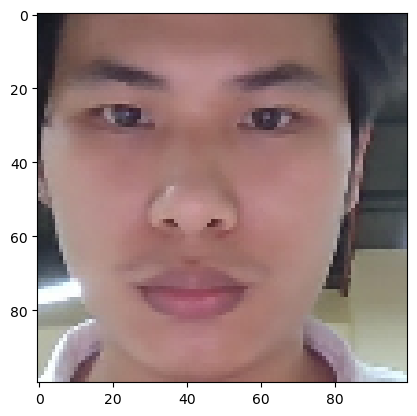

In [33]:
plt.imshow(samp[0])

In [34]:
samp[2]

1.0

In [35]:
round(len(data)*.7)

43

In [36]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [37]:
# Phân chia dữ liệu huấn luyện

# Lấy 70% dữ liệu để làm dữ liệu huấn luyện
train_data = data.take(round(len(data)*.7))

# Chia dữ liệu huấn luyện thành các batch, mỗi batch có 16 mẫu
train_data = train_data.batch(16)

# Tiền xử lý trước 8 batch dữ liệu để tăng tốc độ huấn luyện
train_data = train_data.prefetch(8)
                                

In [38]:
train_samples = train_data.as_numpy_iterator()

In [39]:
train_sample = train_samples.next()

In [40]:
train_sample

(array([[[[0.18946078, 0.17769608, 0.15808824],
          [0.22328432, 0.21151961, 0.18995099],
          [0.22843137, 0.21372549, 0.18039216],
          ...,
          [0.6117647 , 0.47843137, 0.44313726],
          [0.6066176 , 0.4762255 , 0.44093138],
          [0.6039216 , 0.4745098 , 0.4392157 ]],
 
         [[0.16617647, 0.15441176, 0.12696078],
          [0.2112745 , 0.1995098 , 0.17696078],
          [0.22279412, 0.21102941, 0.17769608],
          ...,
          [0.61813724, 0.48259804, 0.44705883],
          [0.6127451 , 0.47941175, 0.44313726],
          [0.6095588 , 0.47916666, 0.44289216]],
 
         [[0.1625    , 0.15073529, 0.11740196],
          [0.19289216, 0.18112744, 0.15563725],
          [0.21617647, 0.21102941, 0.18333334],
          ...,
          [0.6269608 , 0.48259804, 0.44705883],
          [0.6223039 , 0.48014706, 0.44387254],
          [0.6156863 , 0.48235294, 0.44313726]],
 
         ...,
 
         [[0.98137254, 1.        , 0.9990196 ],
          [0.97156

In [41]:
len(train_sample[0])

16

In [42]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

4. Model Engineering

4.1 Build Embedding Layer

In [43]:
inp = Input(shape=(100,100,3), name='input_image')

In [44]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [45]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [46]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [47]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [48]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [49]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [50]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

embedding = make_embedding()

input_image = Input(name='anchor_input', shape=(100, 100, 3))
validation_image = Input(name='validation_input', shape=(100, 100, 3))

anchor_embedding = embedding(input_image)
validation_embedding = embedding(validation_image)

In [52]:
model = make_embedding()

In [53]:
model.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

4.2 Build Distance Layer

In [54]:

class L1Dist(Layer):
    # Lớp khoảng cách L1 Siamese

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    # Biến đổi xảy ra ở đây - tính toán độ tương đồng
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
        

In [55]:
l1 = L1Dist()

In [56]:
l1(anchor_embedding[0], validation_embedding[0])

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_29>

4.3 Make Siamese Model

In [57]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [58]:
inp_embedding = embedding(input_image)

In [59]:
embedding(input_image)

[<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_31>]

In [60]:
inp_embedding = embedding(input_image)
if isinstance(inp_embedding, list):
    inp_embedding = inp_embedding[0]

val_embedding = embedding(validation_image)
if isinstance(val_embedding, list):
    val_embedding = val_embedding[0]

In [61]:
siamese_layer = L1Dist()

In [62]:
distances = siamese_layer(inp_embedding, val_embedding)

In [63]:
classifier = Dense(1, activation='sigmoid')(distances)

In [64]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_35>

In [65]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [66]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[4][0],  │
│                     │                   │            │ embedding[5][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
def make_siamese_model(): 
    
    # Đầu vào hình ảnh Anchor trong mạng
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Hình ảnh Validation trong mạng
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Kết hợp các thành phần khoảng cách siamese
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'

    anchor_embedding = embedding(input_image)
    if isinstance(anchor_embedding, list):
        anchor_embedding = anchor_embedding[0]

    validation_embedding = embedding(validation_image)
    if isinstance(validation_embedding, list):
        validation_embedding = validation_embedding[0]
        
    distances = siamese_layer(anchor_embedding, validation_embedding)

    # Lớp phân loại 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [68]:
siamese_model = make_siamese_model()

In [69]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ embedding[6][0],  │
│                     │                   │            │ embedding[7][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

5 Training

5.1 Setup Loss and Optimizer

In [70]:

# Định nghĩa hàm mất mát Binary Crossentropy
binary_cross_loss = tf.losses.BinaryCrossentropy()


In [71]:

# Định nghĩa bộ tối ưu hóa Adam với learning rate là 0.0001
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001


5.2 Establish Checkpoints

In [72]:
import os

# Đường dẫn lưu trữ checkpoint
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

# Tạo checkpoint để lưu trữ trạng thái của bộ tối ưu hóa và mô hình
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)


5.3 Build Train Step Function

In [73]:
test_batch = train_data.as_numpy_iterator()

In [74]:
batch_1 = test_batch.next()

In [75]:
X = batch_1[:2]

In [76]:
y = batch_1[2]

In [77]:
y

array([0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1.],
      dtype=float32)

In [78]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy',
    dtype=None,
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    Args:
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](htt

In [79]:
@tf.function
def train_step(batch):
    
    # Ghi lại tất cả các hoạt động của chúng ta
    with tf.GradientTape() as tape:     
        # Lấy dữ liệu đầu vào
        X = batch[:2]
        # Lấy nhãn
        y = batch[2]
        
        # Dự đoán với mô hình 
        yhat = siamese_model(X, training=True)
        # Tính toán hàm mất mát 
        loss = binary_cross_loss(y, yhat)
    # In ra giá trị hàm mất mát 
    print(loss)

    # Tính toán gradient của hàm mất mát đối với các tham số của mô hình
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Cập nhật các tham số của mô hình
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss
    

5.4 Build Training Loop

In [80]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [81]:
import tensorflow as tf
from tensorflow.keras.metrics import Recall, Precision
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Tạo các đối tượng metric
        r = Recall()
        p = Precision()
        
        # Vòng lặp qua từng batch
        for idx, batch in enumerate(data):
            # Thực hiện bước huấn luyện
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        # In ra loss, recall và precision sau mỗi epoch
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Lưu checkpoint sau mỗi 10 epoch
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

5.5 Train the model

In [82]:
EPOCHS = 10

In [83]:
train(train_data, EPOCHS)


 Epoch 1/10


D:\Anaconda\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(16, 100, 100, 3))
  warnings.warn(msg)


Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepe
2/3 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step  Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)


D:\Anaconda\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(11, 100, 100, 3))
  warnings.warn(msg)
D:\Anaconda\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(None, 100, 100, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step
0.67034394 0.56 0.93333334

 Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step
0.74948883 0.55 0.84615386

 Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step
0.60066974 0.875 0.9130435

 Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step
0.4404597 0.7894737 0.9375

 Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step
0.4946764 0.8695652 1.0

 Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step
0.357

6. Evaluate Model

6.1 Import Metrics

In [84]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

6.2 Make Predictions

In [85]:

# Lấy một batch dữ liệu kiểm tra
test_input, test_val, y_true = test_data.as_numpy_iterator().next()


In [86]:

# Dự đoán nhãn cho dữ liệu kiểm tra bằng mô hình Siamese
y_hat = siamese_model.predict([test_input, test_val])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [87]:

# Xử lý kết quả dự đoán để chuyển đổi thành nhãn nhị phân
[1 if prediction > 0.5 else 0 for prediction in y_hat ]


[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1]

In [88]:

# Hiển thị nhãn thực tế của dữ liệu kiểm tra
y_true


array([0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
      dtype=float32)

6.3 Calculate Metrics

In [89]:
# Tạo đối tượng metric Recall
m = Recall()

# Tính toán giá trị recall
m.update_state(y_true, y_hat)

# Trả về kết quả Recall
m.result().numpy()

1.0

In [90]:
# Tạo đối tượng metric Precision
m = Precision()

# Tính toán giá trị precision
m.update_state(y_true, y_hat)

# Trả về kết quả Precision
m.result().numpy()

1.0

In [91]:
r = Recall()
p = Precision()

# Duyệt qua từng batch trong tập dữ liệu kiểm tra
for test_input, test_val, y_true in test_data.as_numpy_iterator():
    # Dự đoán nhãn cho dữ liệu kiểm tra bằng mô hình Siamese
    yhat = siamese_model.predict([test_input, test_val])
    # Cập nhật giá trị tri recall va precision
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

# In ra kết quả Recall và Precision
print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1.0 1.0


6.4 Viz Results

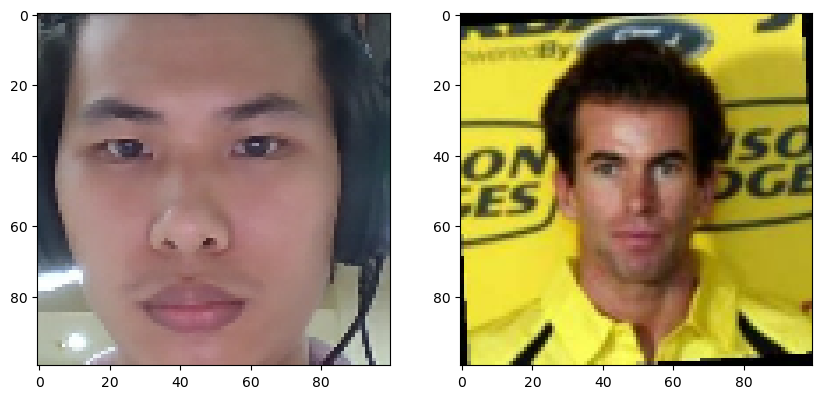

In [92]:
# Thiết lập kích thước đồ thị
plt.figure(figsize=(10,8))

# Thiết lập đồ thị con thứ nhất
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Thiết lập đồ thị con thứ hai
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Hiển thị đồ thị
plt.show()

7. Save Model

In [93]:
siamese_model.save('siamesemodelv2.h5')

In [94]:
L1Dist

__main__.L1Dist

In [95]:
# Reload tensorflow/keras model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [96]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


array([[0.02213388],
       [0.9854656 ],
       [0.05390242]], dtype=float32)

In [97]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

8. Real Time Test

8.1 Verification Function

In [98]:
'application_data/verification_images'

'application_data/verification_images'

In [99]:
import os
os.listdir(os.path.join('application_data', 'verification_images'))

['Aaron_Eckhart_0001.jpg',
 'Alessandro_Nesta_0001.jpg',
 'Alex_Barros_0002.jpg',
 'Alex_Cabrera_0001.jpg',
 'Alex_Popov_0001.jpg',
 'Alex_Sink_0001.jpg',
 'George_W_Bush_0455.jpg',
 'nguyen anh tuan (2).jpg',
 'nguyen anh tuan.jpg',
 'ronaldo.jpg',
 'son tung.jpg',
 'yua mikami.jpg']

In [100]:
import os
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [101]:
import os
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\Aaron_Eckhart_0001.jpg
application_data\verification_images\Alessandro_Nesta_0001.jpg
application_data\verification_images\Alex_Barros_0002.jpg
application_data\verification_images\Alex_Cabrera_0001.jpg
application_data\verification_images\Alex_Popov_0001.jpg
application_data\verification_images\Alex_Sink_0001.jpg
application_data\verification_images\George_W_Bush_0455.jpg
application_data\verification_images\nguyen anh tuan (2).jpg
application_data\verification_images\nguyen anh tuan.jpg
application_data\verification_images\ronaldo.jpg
application_data\verification_images\son tung.jpg
application_data\verification_images\yua mikami.jpg


In [102]:
import os
import numpy as np
# Đảm bảo hàm preprocess đã được định nghĩa ở đây hoặc được import từ một module khác
# Ví dụ:
# def preprocess(image_path):
#     img = cv2.imread(image_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Chuyển đổi sang RGB nếu model mong đợi
#     img = cv2.resize(img, (100,100)) # Thay đổi kích thước phù hợp với model của bạn
#     img = img / 255.0 # Chuẩn hóa pixel
#     return img

def verify(model, detection_threshold, verification_threshold):
    """
    Thực hiện xác minh bằng cách so sánh ảnh đầu vào với các ảnh xác minh.

    Args:
        model: Mô hình Siamese đã được huấn luyện.
        detection_threshold (float): Ngưỡng phát hiện.
            Các dự đoán trên ngưỡng này được coi là dương tính.
        verification_threshold (float): Ngưỡng xác minh.
            Tỷ lệ dự đoán dương tính trên tổng số mẫu dương tính cần đạt để xác minh thành công.

    Returns:
        tuple: (results, verified)
            results (list): Danh sách các điểm tương đồng (scalar) từ mô hình.
            verified (bool): True nếu xác minh thành công, False nếu ngược lại.
    """
    # Khởi tạo danh sách kết quả
    results = []

    # Lặp qua từng ảnh trong thư mục xác minh
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        # Tiền xử lý ảnh đầu vào và ảnh xác minh
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Thêm chiều batch cho từng ảnh (ví dụ: từ (H, W, C) thành (1, H, W, C))
        input_img_batch = np.expand_dims(input_img, axis=0)
        validation_img_batch = np.expand_dims(validation_img, axis=0)
        
        # Thực hiện dự đoán trên mô hình Siamese
        # Giả định model.predict trả về một mảng numpy như [[0.98]]
        raw_result = model.predict([input_img_batch, validation_img_batch])
        results.append(raw_result[0][0]) # Lấy giá trị scalar và thêm vào danh sách

    # Chuyển đổi danh sách kết quả thành mảng numpy để dễ dàng tính toán
    results_array = np.array(results)
        
    # Tính toán số lượng dự đoán dương tính (trên ngưỡng phát hiện)
    detection = np.sum(results_array > detection_threshold)
    
    # Tính toán tỷ lệ xác minh
    num_verification_images = len(os.listdir(os.path.join('application_data', 'verification_images')))
    if num_verification_images == 0:
        verification = 0.0 # Tránh chia cho 0 nếu không có ảnh xác minh
    else:
        verification = detection / num_verification_images
    
    # Xác định xem xác minh có thành công hay không
    verified = verification > verification_threshold
    
    return results, verified

8.2 OpenCV Real Time Verification

In [103]:
import cv2
import os
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [104]:
import numpy as np
np.sum(np.squeeze(results) > 0.9)

NameError: name 'results' is not defined

In [ ]:
results